```
References
Accepted to ACM Transations on Applied Perception (TAP) 2024

MIT License
Copyright (c) 2022 Pontus Ebelin, Gyorgy Denes, Tomas Akenine-Möller, Kalle Åström, 
Magnus Oskarsson, William H. McIlhagga

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:
The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
```

This reference implementation is based on the original Matlab code. 
In the paper, the application results are based on the Matlab implementation.

In [2]:
import numpy as np
import cv2 as cv
from enum import Enum

In [3]:
class FilterType(Enum):
    T_ALL = 0  # final filter from the paper
    D_ALL = 4  # analytical disef function fitted to t_all, sampled

def get_temporal_edge_filter(t, ffilter: FilterType = FilterType.D_ALL):
    """ 
    Return the temporal edge filter from the paper.

    Parameters
    ----------
    
    t : np.ArrayLike<float32>
        time points to sample the filter at

    ffilter : FilterType
        type of filter to use. Defaults to d_all
    
    """
    if ffilter == FilterType.D_ALL:
        s_in_sec = 0.016  # s value from paper
        amp = 148
        t0 = np.mean(t)
        t = t - t0
        filt = -amp * np.sign(t) * np.exp(-np.abs(t)/s_in_sec)
    elif ffilter == FilterType.T_ALL:
        samples = np.array([2.380681037902832031e-01, -3.177686214447021484e+00, -1.703772783279418945e+00, -8.107570409774780273e-01, 3.285695016384124756e-01, -7.167906761169433594e-01, 2.733870744705200195e+00, 1.208868598937988281e+01, 2.555757522583007812e+01, 4.278320312500000000e+01, 5.342393517494201660e-01, -4.472121047973632812e+01, -2.688981056213378906e+01, -1.345495414733886719e+01, -5.092443943023681641e+00, -1.369577884674072266e+00, -4.700142741203308105e-01, 1.906259655952453613e+00, 4.587969779968261719e+00, 5.420155048370361328e+00, 2.884223461151123047e+00], dtype=np.float32)
        samplets = np.arange(0, samples.shape[0]) / 60
        filt = np.interp(t, samplets, samples)
    
    # tcsf currently not supported, as the stelaCSF reference implementation is in Matlab

    # remove nan values
    filt = filt[~np.isnan(filt)]
    t = t[~np.isnan(filt)]

    # normalise so +ves sum to 1, -ves sum to -1
    filt[filt > 0] = filt[filt>0] / np.sum(filt[filt>0])
    filt[filt < 0] = -filt[filt<0] / np.sum(filt[filt<0])

    return filt, t
    

In [4]:
def predict_flicker_in_image(frame_a, frame_b, ppd: float = 52.0, fps: int = 120, ffilter: FilterType = FilterType.D_ALL, psyalpha: float = -0.1008, psybeta: float = 0.9061):
    """
    Predict the amount of flicker visible when displaying a pair of alternating frames

    Paramters
    ---------

    frame_a: np.ArrayLike<float32,float32,float32>
        frame in CIE XYZ

    frame_b: np.ArrayLike<float32,float32,float32>
        frame in CIE XYZ

    ppd: float = 52.0
        pixels per angular degrees. Defaults to 52 ppd

    fps: int = 120
        frames per second. Defaults to 120

    ffilter: FilterType = D_ALL
        temporal edge detection to use

    
    psyalpha: float
        alpha value of psychometric function. Default: best fitting reported in paper for D_ALL

    psybeta: float
        beta value of psychometric function. Default: best fitting reported in paper for D_ALL
    """
    assert(frame_a.shape == frame_b.shape)

    # create a 1.0 second video with 2 samples per frame
    SAMPLES_PER_FRAME = 2
    t = np.linspace(0, 1, fps * SAMPLES_PER_FRAME + 1)

    # video frames (luminance only)
    vid = np.zeros((t.shape[0], frame_a.shape[0], frame_a.shape[1]))
    allmask = np.arange(0, t.shape[0])
    amask = (allmask // SAMPLES_PER_FRAME) % 2 == 0
    bmask = (allmask // SAMPLES_PER_FRAME) % 2 == 1
    vid[amask,:,:] = frame_a[:,:,1]  # luminance is at channel 1
    vid[bmask,:,:] = frame_b[:,:,1]

    # filtering
    filt, tfilt = get_temporal_edge_filter(t[t < 0.9], ffilter)
    filtered = np.apply_along_axis(lambda m: np.convolve(m, filt, "valid"), axis=0, arr=vid)
    filtered = np.squeeze(np.max(np.abs(filtered), axis=0))
    filtered = cv.GaussianBlur(filtered, (0,0), sigmaX=int(0.36*ppd), sigmaY=int(0.36*ppd), borderType=cv.BORDER_REFLECT)

    P = 1 - np.exp(psyalpha * np.power(filtered, psybeta))
    return P


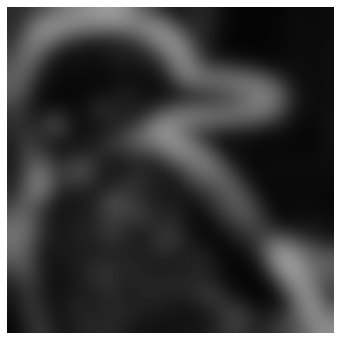

In [5]:
from matplotlib import pyplot as plt 
def show_image(img):
    plt.figure(figsize=(6*img.shape[1] / img.shape[0], 6))
    plt.axis('off')
    if np.ndim(img) == 2:
        plt.imshow(img, cmap='gray', vmin=0, vmax=1)
    else:
        plt.imshow(img[:,:,:])


import h5py
IMAGE_NUM = 9
with h5py.File('stimuli.mat', 'r') as f:
    frame_as = np.array(f.get("stimuli").get("ref"))
    frame_a_XYZ = np.moveaxis(np.moveaxis(np.squeeze(frame_as[:,:,:,IMAGE_NUM]), 0, -1), 1, 0)
    frame_bs = np.array(f.get("stimuli").get("blur"))
    frame_b_XYZ = np.moveaxis(np.moveaxis(np.squeeze(frame_bs[:,:,:,IMAGE_NUM]), 0, -1), 1, 0)
    
P = predict_flicker_in_image(frame_a_XYZ, frame_b_XYZ, 52, 120)

show_image(P)